# MUDE W3- Gradient Estimation 



<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>

<b>Info:</b> 

This notebook is a very simple draft showing how we could use data from the ~~Nenana Ice Classic~~ (from any of the column in our dateset) for the numerical modelling part of MUDE.

The implementation is not particularly efficient, but it is quite flexible.


The dataset used is direclty loaded from github, so a a few extra packages are needed(`io` and  `requests`) but we could avoid using 'non-standard'libraries by downloading the file and loading it 'manually'.

</p>
</div>


In [16]:
from io import StringIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly 

def import_data_browser(url):
    """
    This function imports data from a specified URL.

    Parameters:
    url (str): The URL from which to import the data.

    Returns:
    None

    Comments:
    This function is needed to load data in a browser, as the environment used does not support absolute/relative path imports 
    """
   
    response = requests.get(url)
    csv_data = StringIO(response.text)

    return csv_data


# Loading the dataset

In [17]:

# we could load the data from the repo
file=import_data_browser('https://raw.githubusercontent.com/iceclassic/mude/main/book/data_files/time_serie_data.txt')
Data=pd.read_csv(file,skiprows=162,index_col=0,sep='\t')
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39309 entries, 1901-02-01 to 2024-02-06
Data columns (total 28 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Regional: Air temperature [C]                      38563 non-null  float64
 1   Days since start of year                           38563 non-null  float64
 2   Days until break up                                38563 non-null  float64
 3   Nenana: Rainfall [mm]                              29547 non-null  float64
 4   Nenana: Snowfall [mm]                              19945 non-null  float64
 5   Nenana: Snow depth [mm]                            15984 non-null  float64
 6   Nenana: Mean water temperature [C]                 2418 non-null   float64
 7   Nenana: Mean Discharge [m3/s]                      22562 non-null  float64
 8   Nenana: Air temperature [C]                        31171 non-null  fl

## Estimating gradients


In [19]:
def finite_differences(series):
    """Compute forward, central, and backward differences using the step size as days between measurement
    """
   
    days_forward = (series.index.to_series().shift(-1) - series.index.to_series()).dt.days
    days_backward = (series.index.to_series() - series.index.to_series().shift(1)).dt.days
    
    # Forward difference: (f(x+h) - f(x)) / h 
    forward = (series.shift(-1) - series) / days_forward

    # Backward difference: (f(x) - f(x-h)) / h,
    backward = (series - series.shift(1)) / days_backward

    # Central difference: (f(x+h) - f(x-h)) / (h_forward + h_backward)
    central = (series.shift(-1) - series.shift(1)) / (days_forward + days_backward) #
    
    # fixing start/end points
    forward.iloc[-1] = np.nan  
    backward.iloc[0] = np.nan  

    return pd.DataFrame({'forward': forward, 'backward': backward, 'central': central})

# Ice thickness

In [20]:
Ice_thickness=Data['IceThickness [cm]']
Ice_thickness=Ice_thickness.dropna(inplace=False) # drop the missing values

result = Ice_thickness.groupby(Ice_thickness.index.year).apply(lambda x: finite_differences(x))
result = result.reset_index(level=0, drop=True)

if we were to implement other methods, we simply create the function and  pass  it in the `apply`. 

### Ploting the gradients,
 We will probably use better/more refined plots, but this is useful to get a quick idea of the results.

In [21]:


def plot_gradients(ax, x, y, slopes, length=2, color='blue', label=None, label_flag=True, offset=0):
    """Plot lines with slopes at given points on a plot and annotate them."""
    #
    # code(annotations) shamelessly stolen fr chatgpt
    annotations = []
    for i in range(len(x)):
        if np.isnan(slopes.iloc[i]):
            continue  
        dx = length  
        dy = slopes.iloc[i] * dx  
        
        ax.plot(
            [x[i], x[i] + pd.Timedelta(days=dx)], 
            [y.iloc[i], y.iloc[i] + dy], 
            color=color, alpha=0.7, label=label if label_flag else ""
        )
        
        annotations.append({
            'x': x[i] + pd.Timedelta(days=dx / 2),
            'y': y.iloc[i] + offset,
            'text': f'{slopes.iloc[i]:.2f}',
            'color': color
        })
        label_flag = False  #


    for annotation in annotations:
        ax.annotate(
            annotation['text'], 
            (annotation['x'], annotation['y']), 
            color=annotation['color'], fontsize=10, ha='center'
        )

def plot_gradients_and_thickness(result, col, year, plot_gradient_as_slope=False,Title=None,ylabel=None):
    """
    Plots ice thickness gradients and ice thickness for a selected year.

    Parameters:
    - result (pd.DataFrame): DataFrame containing the gradients with columns ['forward', 'backward', 'central'].
    - col (pd.Series): Series containing the columns values indexed by datetime.
    - year (int): The year to filter and plot data for.
    - plot_gradient_as_slope (bool): If True, plots lines with gradients and annotations.
    - Title(str) title of the plot
    - ylabel(str) ylabel of the plot
    """
    
    result_year = result[result.index.year == year]
    col_year = col[col.index.year == year]
    
    if not plot_gradient_as_slope:
        fig, ax1 = plt.subplots(figsize=(20, 5))

        ax1.plot(result_year['forward'], label='Forward', color='red')
        ax1.plot(result_year['backward'], label='Backward', color='green')
        ax1.plot(result_year['central'], label='Central', color='blue')

        ax1.set_ylabel(ylabel)
        ax1.set_xlabel('Date')
        ax1.set_title(Title)
        ax1.grid()
        #ax1.set_ylim([-5, 4])

      
        ax1.set_xlim(result_year.index.min(), result_year.index.max())
        ax1.legend(loc='upper left')

      
        ax2 = ax1.twinx()
        ax2.scatter(col_year.index, col_year, color='black', alpha=0.4, label='data')
        ax2.plot(col_year.index, col_year, color='black', alpha=0.4)
        #ax2.set_ylabel('Ice Thickness [cm]')

       
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(20, 5))

        ax.plot(col_year.index, col_year, label='Thickness', color='black', linestyle='--', alpha=0.4)
        ax.scatter(col_year.index, col_year, color='black', alpha=0.4)

      
        offsets = {'forward': -3, 'backward': -6, 'central': -9}

        
        for grad_type, color in zip(['forward', 'backward', 'central'], ['red', 'green', 'blue']):
            slopes = result_year[grad_type]
            plot_gradients(ax, result_year.index, col_year, slopes, color=color, label=grad_type.capitalize(), label_flag=True, offset=offsets[grad_type])

        ax.legend()
        ax.set_title(Title)
        ax.set_xlabel('Date')
        ax.set_ylabel(ylabel)
        ax.grid(True)
        plt.show()




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 461 entries, 1989-02-26 to 2023-04-21
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   forward   426 non-null    float64
 1   backward  426 non-null    float64
 2   central   391 non-null    float64
dtypes: float64(3)
memory usage: 14.4 KB


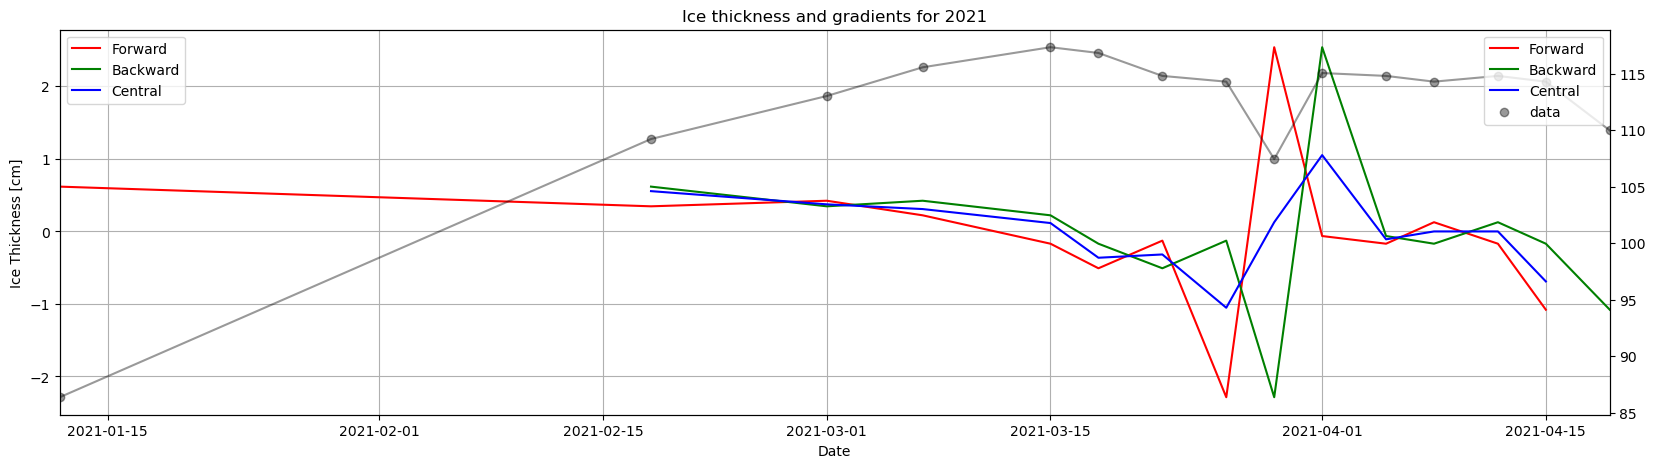

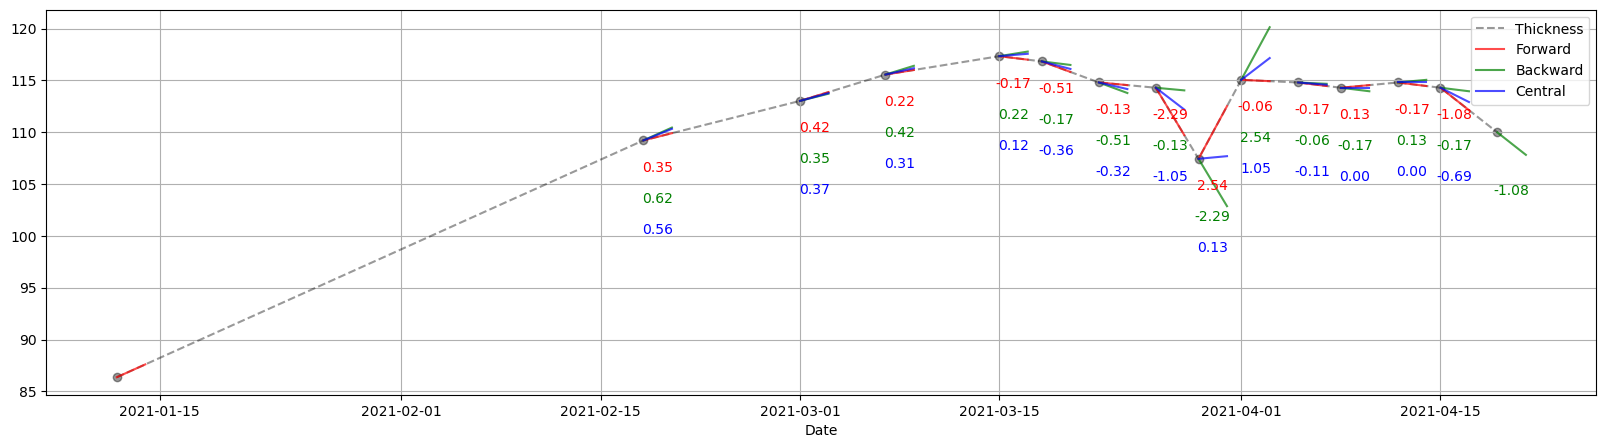

             forward  backward   central
2021-01-12  0.617838       NaN       NaN
2021-02-18  0.346364  0.617838  0.555625
2021-03-01  0.423333  0.346364  0.373529
2021-03-07  0.222250  0.423333  0.308429
2021-03-15 -0.169333  0.222250  0.115455
2021-03-18 -0.508000 -0.169333 -0.362857
2021-03-22 -0.127000 -0.508000 -0.317500
2021-03-26 -2.286000 -0.127000 -1.052286
2021-03-29  2.540000 -2.286000  0.127000
2021-04-01 -0.063500  2.540000  1.052286
2021-04-05 -0.169333 -0.063500 -0.108857
2021-04-08  0.127000 -0.169333  0.000000
2021-04-12 -0.169333  0.127000  0.000000
2021-04-15 -1.079500 -0.169333 -0.689429
2021-04-19       NaN -1.079500       NaN


In [22]:
result.info()
plot_gradients_and_thickness(result, Ice_thickness, 2021,Title='Ice thickness and gradients for 2021',ylabel='Ice Thickness [cm]')

plot_gradients_and_thickness(result, Ice_thickness, 2021,plot_gradient_as_slope=True)

print(result[result.index.year==2021])

## Now with the Discharge

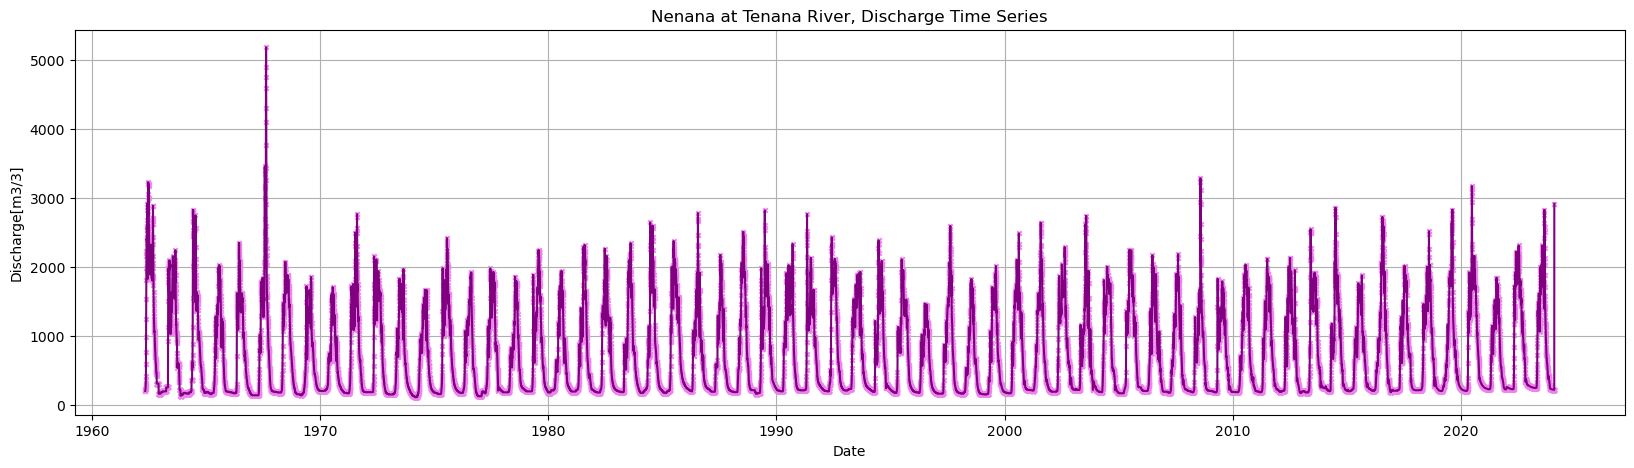

In [23]:
Discharge=Data['Nenana: Mean Discharge [m3/s]']
Discharge=Discharge.dropna(inplace=False) # drop the missing values

plt.figure(figsize=(20,5))
plt.plot(Discharge,color='purple')
plt.scatter(Discharge.index,Discharge,color='violet',marker='x',s=10)
plt.title('Nenana at Tenana River, Discharge Time Series')
plt.ylabel('Discharge[m3/3]')
plt.xlabel('Date')
plt.grid()
plt.show()


Computing the gradients

In [24]:
result_2 = Discharge.groupby(Discharge.index.year).apply(lambda x: finite_differences(x))
result_2 = result_2.reset_index(level=0, drop=True)

function we can make quick plot

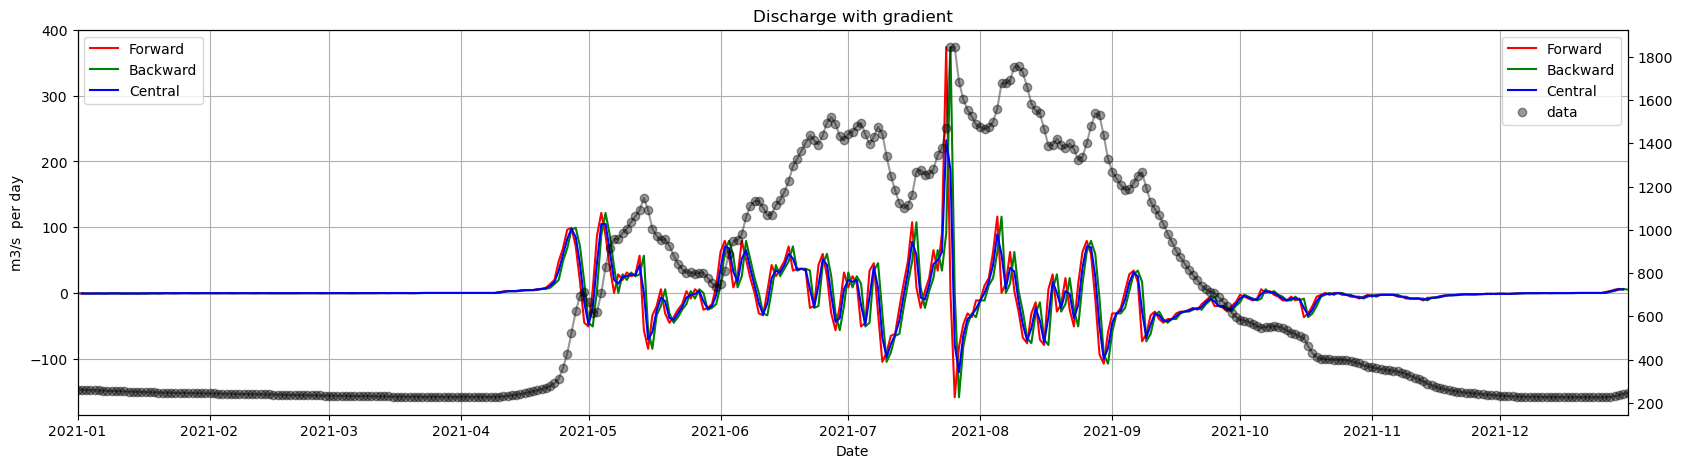

            forward  backward  central
2021-01-01  -0.5664       NaN      NaN
2021-01-02  -0.8496   -0.5664  -0.7080
2021-01-03  -0.8496   -0.8496  -0.8496
2021-01-04  -0.8496   -0.8496  -0.8496
2021-01-05  -0.5664   -0.8496  -0.7080
...             ...       ...      ...
2021-12-27   3.1152    1.6992   2.4072
2021-12-28   5.0976    3.1152   4.1064
2021-12-29   6.2304    5.0976   5.6640
2021-12-30   5.0976    6.2304   5.6640
2021-12-31      NaN    5.0976      NaN

[365 rows x 3 columns]


In [25]:
plot_gradients_and_thickness(result_2, Discharge, 2021,Title='Discharge with gradient',ylabel='m3/s  per day')

print(result_2[result_2.index.year==2021])

## Gage Height


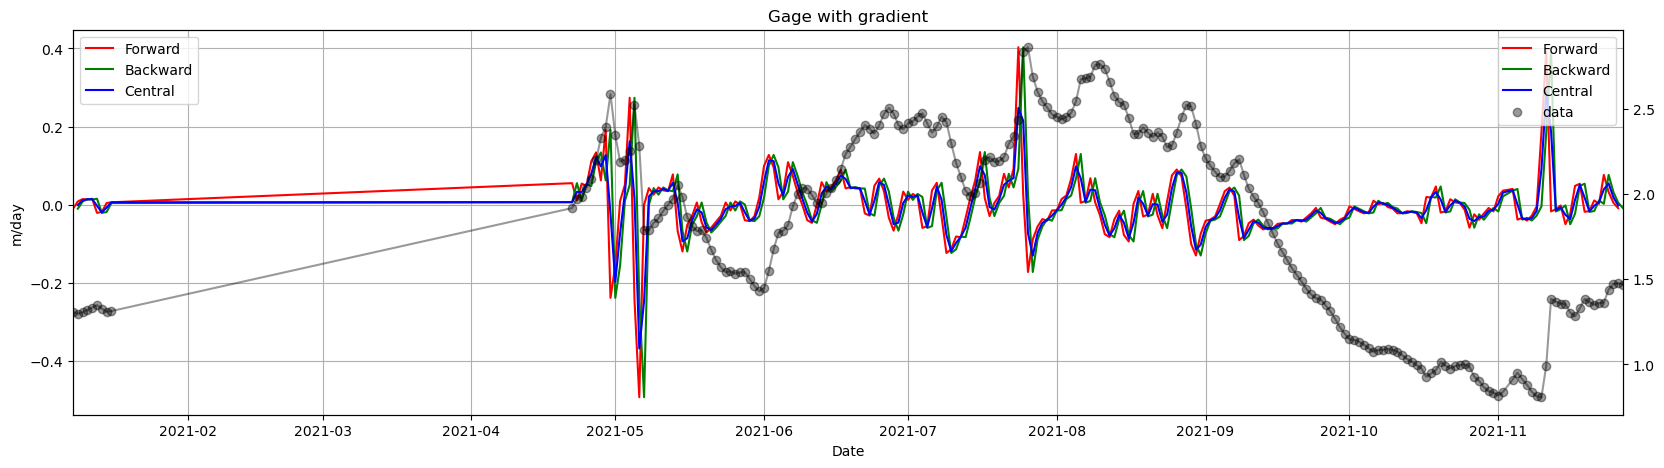

In [26]:
Gage=Data['Nenana: Gage Height [m]']
Gage=Gage.dropna(inplace=False) # drop the missing values
result_3 = Gage.groupby(Gage.index.year).apply(lambda x: finite_differences(x))
result_3 = result_3.reset_index(level=0, drop=True)
plot_gradients_and_thickness(result_3, Gage, 2021,Title='Gage with gradient',ylabel='m/day')